In [1]:
import torch

from data import data_helper
from data.data_helper import available_datasets
from models import model_factory
from optimizer.optimizer_helper import get_optim_and_scheduler
from torch.nn import functional as F
from torch import nn

from utils.Logger import Logger

import torchvision
import matplotlib.pyplot as plt

# from train_jigsaw import do_training
from utils import vis

class Container():
    pass

args = Container()
args.batch_size = 128
args.jigsaw_n_classes = 31
args.n_classes = 7
args.learning_rate = 0.001
args.epochs = 30
args.source = ["art_painting", "photo", "cartoon"]
args.target = "sketch" # source[target_id]
args.network = "caffenet"
args.jig_weight = 0.0
args.tf_logger = True
args.val_size = 0.1

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
from train_jigsaw import Trainer

trainer = Trainer(args, device)
logger, model = trainer.do_training()

Using Caffe AlexNet
AlexNetCaffe(
  (features): Sequential(
    (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (relu1): ReLU(inplace)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (norm1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1)
    (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
    (relu2): ReLU(inplace)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (norm2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1)
    (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace)
    (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (relu4): ReLU(inplace)
    (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (relu5): ReLU(inplace)
    (pool5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)

Accuracies on val: jigsaw : 0.011570, class : 0.847934
Accuracies on test: jigsaw : 0.000000, class : 0.470858
New epoch - lr: 0.0, 0.001
0/42 of epoch 11/30 jigsaw : 3.506238, class : 0.576392 - acc jigsaw : 0.007812, class : 0.765625 [bs:128]
10/42 of epoch 11/30 jigsaw : 3.479024, class : 0.633789 - acc jigsaw : 0.023438, class : 0.804688 [bs:128]
20/42 of epoch 11/30 jigsaw : 3.487110, class : 0.743575 - acc jigsaw : 0.062500, class : 0.718750 [bs:128]
30/42 of epoch 11/30 jigsaw : 3.508566, class : 0.791667 - acc jigsaw : 0.046875, class : 0.695312 [bs:128]
40/42 of epoch 11/30 jigsaw : 3.503610, class : 0.679428 - acc jigsaw : 0.039062, class : 0.750000 [bs:128]
Accuracies on val: jigsaw : 0.019835, class : 0.841322
Accuracies on test: jigsaw : 0.000255, class : 0.489692
New epoch - lr: 0.0, 0.001
0/42 of epoch 12/30 jigsaw : 3.464341, class : 0.689953 - acc jigsaw : 0.015625, class : 0.773438 [bs:128]
10/42 of epoch 12/30 jigsaw : 3.478887, class : 0.720907 - acc jigsaw : 0.0156

0/42 of epoch 23/30 jigsaw : 3.473187, class : 0.512245 - acc jigsaw : 0.007812, class : 0.804688 [bs:128]
10/42 of epoch 23/30 jigsaw : 3.476584, class : 0.485004 - acc jigsaw : 0.046875, class : 0.796875 [bs:128]
20/42 of epoch 23/30 jigsaw : 3.501595, class : 0.617349 - acc jigsaw : 0.031250, class : 0.781250 [bs:128]
30/42 of epoch 23/30 jigsaw : 3.489735, class : 0.563362 - acc jigsaw : 0.054688, class : 0.781250 [bs:128]
40/42 of epoch 23/30 jigsaw : 3.477718, class : 0.495781 - acc jigsaw : 0.046875, class : 0.796875 [bs:128]
Accuracies on val: jigsaw : 0.019835, class : 0.864463
Accuracies on test: jigsaw : 0.004581, class : 0.475694
New epoch - lr: 0.0, 0.001
0/42 of epoch 24/30 jigsaw : 3.478226, class : 0.536492 - acc jigsaw : 0.062500, class : 0.835938 [bs:128]
10/42 of epoch 24/30 jigsaw : 3.481383, class : 0.437946 - acc jigsaw : 0.031250, class : 0.835938 [bs:128]
20/42 of epoch 24/30 jigsaw : 3.485421, class : 0.520126 - acc jigsaw : 0.031250, class : 0.789062 [bs:128]


45.02417918045304


<IPython.core.display.Javascript object>


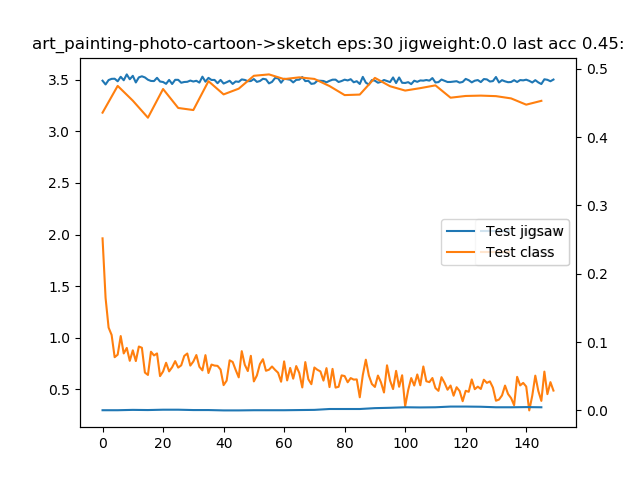

In [3]:
%matplotlib notebook
print(100*(logger.val_acc["class"][-1] + logger.val_acc["class"][-2])/2.)
vis.view_training(logger, "%s->%s eps:%d jigweight:%.1f" % ("-".join(args.source),
                                                            args.target,args.epochs, args.jig_weight))

In [ ]:
dataloaders = {"train": data_helper.get_dataloader(args.source, args.jigsaw_n_classes, "train"),
           "val": data_helper.get_dataloader(args.target, args.jigsaw_n_classes, "val")}
dataset_sizes = {"train": len(dataloaders["train"].dataset),
                "val": len(dataloaders["val"].dataset)}
print(dataset_sizes)

In [ ]:
def get_optim_and_scheduler(network, epochs, lr):
    from torch import optim
    optimizer = optim.SGD(network.get_params(lr), weight_decay=.0005, momentum=.9, nesterov=True, lr=lr)
    step_size = int(epochs * .8)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size)
    print(step_size)
    return optimizer, scheduler

model_ft = model_factory.get_network("caffenet")(jigsaw_classes=args.jigsaw_n_classes+1, classes=args.n_classes)
model_ft = model_ft.to(device)
# print(model_ft)

optimizer, scheduler = get_optim_and_scheduler(model_ft, args.epochs, args.learning_rate)

In [ ]:
def do_epoch(model, source, target, optimizer, logger, device):
    criterion = nn.CrossEntropyLoss()
    model.train()
    for it, ((data, jig_l, class_l), d_idx) in enumerate(source):
        data, jig_l, class_l = data.to(device), jig_l.to(device), class_l.to(device)
        
        optimizer.zero_grad()
        
        jigsaw_logit, class_logit = model(data)
        jigsaw_loss = criterion(jigsaw_logit, jig_l)
        class_loss = criterion(class_logit[d_idx!=target_id], class_l[d_idx!=target_id])
        _, cls_pred = class_logit.max(dim=1)
        _, jig_pred = jigsaw_logit.max(dim=1)
        loss = class_loss + jigsaw_loss * jig_weight
        
        loss.backward()
        optimizer.step()

        logger.log(it, len(source), {"jigsaw": jigsaw_loss.item(), "class": class_loss.item()},
                  {"jigsaw": torch.sum(jig_pred == jig_l.data).item(), "class":torch.sum(cls_pred == class_l.data).item()},
                  data.shape[0])
        del loss, class_loss, jigsaw_loss, jigsaw_logit, class_logit

    model.eval()
    with torch.no_grad():
        jigsaw_correct = 0
        class_correct = 0
        total = 0
        for it, ((data, jig_l, class_l), d_idx) in enumerate(target):
            data, jig_l, class_l = data.to(device), jig_l.to(device), class_l.to(device)
            jigsaw_logit, class_logit = model(data)
            _, cls_pred = class_logit.max(dim=1)
            _, jig_pred = jigsaw_logit.max(dim=1)
            class_correct += torch.sum(cls_pred == class_l.data)
            jigsaw_correct += torch.sum(jig_pred == jig_l.data)
            total += data.shape[0]
        logger.log_test({"jigsaw": float(jigsaw_correct) / total,
                         "class": float(class_correct) / total})


def do_training(args, model, source, target, optimizer, scheduler, device):
    logger = Logger(args)
    for k in range(args.epochs):
        scheduler.step()
        logger.new_epoch(scheduler.get_lr())
        do_epoch(model, source, target, optimizer, logger, device)
    return logger, model

In [ ]:
jig_weight = args.jig_weight
logger, model = do_training(args, model_ft, dataloaders["train"], dataloaders["val"], optimizer, scheduler, device)

In [ ]:
%matplotlib notebook
print(100*(logger.val_acc["class"][-1] + logger.val_acc["class"][-2])/2.)
vis.view_training(logger, "%s->%s eps:%d jigweight:%.1f" % (str(args.source),args.target,args.epochs, jig_weight))

In [ ]:
def to_plt(inp):
    import numpy as np
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    return inp

conv1 = model_ft.features[0] # models.alexnet(pretrained=True).features[0] #model_ft.features[0]
tmp = conv1.weight.cpu().data
tmp = torchvision.utils.make_grid(tmp,normalize=True)
plt.imshow(to_plt(tmp))
plt.show()

In [ ]:
vis.view_training(logger, "%s->%s eps:%d jigweight:%.1f" % (str(source),target,epochs, jig_weight))

In [ ]:
fig, ax1 = plt.subplots()
for k,v in logger.losses.items():
    ax1.plot(v, label=k)
    l = len(v)
updates = l / len(logger.val_acc)
print(updates)
plt.legend()
ax2 = ax1.twinx()
ax2.plot(range(0,l,int(updates)), logger.val_acc, label="Test acc", c='g')
plt.legend()
plt.show()

In [ ]:
for e,k in enumerate(range(0,l,int(updates))):
    print(k, logger.val_acc[e])

In [ ]:



# iter_c = iter(train_datasets)

# for x in range(5):
#     tmp = next(iter_c)
#     image = to_plt(tmp[0])
#     plt.imshow(image)
#     plt.show()

In [ ]:
from os.path import join, dirname
# from data.JigsawLoader import JigsawTestDataset
import torch
import matplotlib.pyplot as plt
import numpy as np


def to_plt(inp):
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
    return inp

# dataset = JigsawTestDataset("", join('data/txt_lists', 'dslr_train.txt'), patches=False, classes=31)
# test = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, drop_last=False)
iter_c = iter(data_helper.get_dataloader("photo", 31, "train"))
(tmp, v, c), d = next(iter_c)
for x in range(5):
    image = tmp[x]
    image = torchvision.utils.make_grid(tmp[x],1,normalize=True)
    plt.imshow(to_plt(image))
    plt.show()
    print(v[x],c[x])
    
print(v.max(), v.min())

In [ ]:
v

In [ ]:
[d[d==k].shape for k in [0,1]]


In [ ]:
from data.JigsawLoader import JigsawDataset
from PIL import Image
import torchvision.transforms as transforms

class JigsawTestDataset(JigsawDataset):
    def __init__(self, *args, **xargs):
        super().__init__(*args, **xargs)
        self._augment_tile = transforms.Compose([
#             transforms.RandomCrop(64),
            transforms.Resize((75, 75), Image.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
    def __getitem__(self, index):
        framename = self.data_path + '/' + self.names[index]
        img = Image.open(framename).convert('RGB')
        img = self._image_transformer(img)

        w = float(img.size[0]) / self.grid_size
        n_grids = self.grid_size ** 2
        tiles = [None] * n_grids
        for n in range(n_grids):
            y = int(n / self.grid_size)
            x = n % self.grid_size
            tile = img.crop([x * w, y * w, (x + 1) * w, (y + 1) * w])
            tile = self._augment_tile(tile)
            tiles[n] = tile

        data = torch.stack(tiles, 0)
        return self.returnFunc(data), 0, int(self.labels[index])


In [ ]:
dataset = JigsawTestDataset("", join('data/txt_lists', 'dslr_train.txt'), patches=False, classes=31)